Abstract

> "Condition Monitoring involves continuous assessment of various parameters to assess the health of mechanical components. This is achieved by gathering data from sensors in real-time, allowing for ongoing monitoring of component performance and condition over time. Predictive Maintenance strategies can be developed using Anomaly Detection techniques, that use Machine Learning algorithms to identify abnormal patterns or behaviors in data that may indicate potential issues. The idea of simultaneously increasing equipment availability while reducing maintenance costs has generated significant interest from industry stakeholders. Depending on the specific use cases, predictive maintenance offers notable benefits, including increased machine uptime, reduced maintenance hours and material used, as well as enhanced stability in machine outputs, shorter lead times, and fewer forced outages. In this paper, we propose a condition monitoring method for gearboxes based on vibration, ultrasound, and oil analysis. To achieve this, an effective anomaly detection algorithm is necessary to detect faults at an early stage and facilitate timely maintenance actions. Our proposed analysis extensively evaluates Test7B, a gearbox test bench. Throughout its lifecycle, numerous inspections have been conducted to generate a supervised dataset for training and testing real-time Anomaly Detection models. The aim is to compare the sensitivity and robustness of different approaches. Additionally, if the Anomaly score exceeds a certain threshold for a specified period, more focused techniques such as Time Series Analysis (TSA) or envelope analysis for ultrasonic sensors are applied to classify the anomaly with greater accuracy."



Keywords: Condition monitoring, ultrasonic data analysis, predictive maintenance, pattern recognition, Anomaly Detection.

The data we are going to analyse were obtained from Test7B, conducted in collaboration with S.T.M. Riduttori. The sensors used include two IEPE accelerometers (Alma_IN and ALMA_OUT), two ultrasonic sensors (SDT1 and SDT2), a thermocouple (PT_IN), and the encoder signal (rpmalma_01), all belonging to the AI "Analog Input" signal class. In addition, there are oil quality signals, recorded on the CAN0 channel.

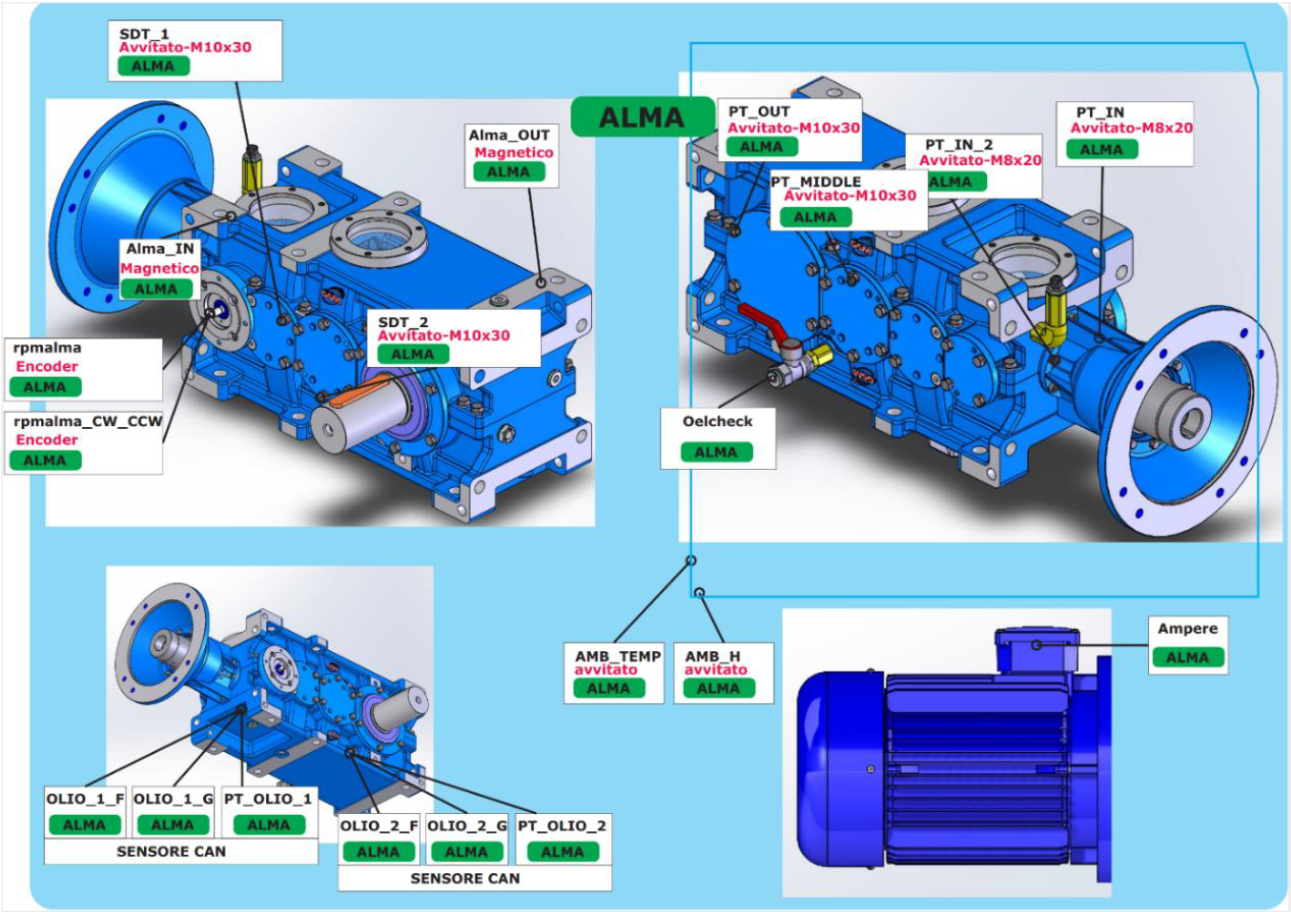

In [1]:
from IPython.display import Image
Image("C:/Users/franc/Desktop/Notebook_CoMo/Sensori banco prova riduttore Test7B.png") # Insert the path of the image

The total duration of the test was 2187.5 hours. the test consisted of the gearbox executing a cycle divided into 12 working points (6 clockwise and 6 anticlockwise). The high-frequency signal acquisitions (50 kHz), lasting approximately 150 seconds, were carried out every 30 minutes of gearbox operation. As for the extraction of features from the signal detected by the sensors (Alma_IN, Alma_OUT, SDT1, SDT2), we start with the extraction of generic features for signal analysis, which include: RMS, CrestFactor, Kurtosis, Skewness, Peak2peak. In addition, specific features are added for gears and bearings, which depend on their geometry, such as: axis orderings, gear sidebands and main bearing frequencies (the latter for now only for IEPE accelerometers). 

In this Notebook, only the 'metadata' will be analysed, i.e. of all the high-frequency acquisitions of approximately 150 seconds, only the mean, maximum, minimum and standard deviation of all the previously mentioned features are stored. Mainly in the analysis of outlier removal, classification and anomaly detection we will use the mean value.

# Loading the dataset locally
Loading the TDMS file and initial preprocessing for the extraction of channels and groups from the original files!

In [2]:
import numpy as np
import pandas as pd
from nptdms import TdmsFile
# Carica il file TDMS
Test7B = TdmsFile.read('C:/AASourceCode/Notebook/CoMo_nb/STM_test7B_repository/Test7B_MetaData_Results.tdms') # Insert the path of the TDMS file

# Ottieni i nomi dei canali all'interno del gruppo Monitored_State_Average
all_channel_names = [channel.name for channel in Test7B['Monitored State_Average'].channels()]

# Select only the channels from the third element to the 418th element
channel_names = all_channel_names[0:416]

# Inizializza le variabili
features_Test = np.zeros((4376, 416))
Name = ['Ampere', 'RPM']

# Concatena i dati di WP_Ampere e WP_rpmalma
IN = np.vstack((Test7B['Working Point_Average']['WP_Ampere'].data,
                Test7B['Working Point_Average']['WP_rpmalma'].data)).T

# Esegui un loop su tutti i canali tranne i primi due
for jj, channel_name in enumerate(channel_names):
    features_Test[:, jj] = Test7B['Monitored State_Average'][channel_name].data

    # Aggiungi il nome del canale
    Name.append(channel_name[5:])

# Crea un DataFrame con le variabili IN e features_Test
data = np.concatenate((IN, features_Test), axis=1)

# Crea una lista di nomi di colonne per il DataFrame
columns = Name

# Crea il DataFrame
STM7Bdata_ft_418 = pd.DataFrame(data, columns=columns)

C:\Users\franc\AppData\Local\Temp\ipykernel_57320\3698687022.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Visualisation of certain dataset features

Thanks to the drop-down menu, it is possible to select the features saved in the DataFrame containing 418 features including Ampere and RPM, and display them throughout the 4376-sample test.

In [3]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def plot_column(column_to_plot):
    # Plot the selected column
    plt.figure(figsize=(20, 6))
    plt.plot(STM7Bdata_ft_418[column_to_plot]) #marker='o', color='blue', markerfacecolor='red', markersize=5)  # Add color parameters
    plt.title(f'{STM7Bdata_ft_418[column_to_plot].name}')  # Use the column name as the title
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Get the list of column names
column_names = STM7Bdata_ft_418.columns.tolist()

# Create a dropdown menu for column names and a plot button
interact(plot_column, column_to_plot=column_names);

interactive(children=(Dropdown(description='column_to_plot', options=('Ampere', 'RPM', 'Alma_IN_RMS', 'Alma_IN…

In addition, a different display mode, in which the chosen feature is highlighted with a different coloured marker.

In [4]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the app layout
app.layout = html.Div([
    dcc.Dropdown(
        id='column-dropdown',
        options=[{'label': i, 'value': i} for i in STM7Bdata_ft_418.columns.tolist()],
        value=STM7Bdata_ft_418.columns[0]
    ),
    dcc.Graph(id='graph')
])

# Define the callback to update the graph
@app.callback(
    Output('graph', 'figure'),
    [Input('column-dropdown', 'value')]
)
def update_graph(column_to_plot):
    fig = go.Figure(data=go.Scatter(y=STM7Bdata_ft_418[column_to_plot], mode='lines+markers',
        line=dict(color='blue'),  # Change line color to blue
        marker=dict(color='red')))  # Change marker color to red))
    fig.update_layout(
        title={
            'text': f'{column_to_plot}',
            'x': 0.5,  # Center the title
            'xanchor': 'center'  # Anchor the title at its center
        },
        xaxis_title='Samples',
        yaxis_title='Amplitude',
        autosize=True,
        #width=20*100,  # width in pixels
        height=6*100,  # height in pixels
    )
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

ModuleNotFoundError: No module named 'dash'

Display of the Working Points of the original dataset, with regard to the INPUT variables namely: 'Ampere' and 'RPM' as a function of time.

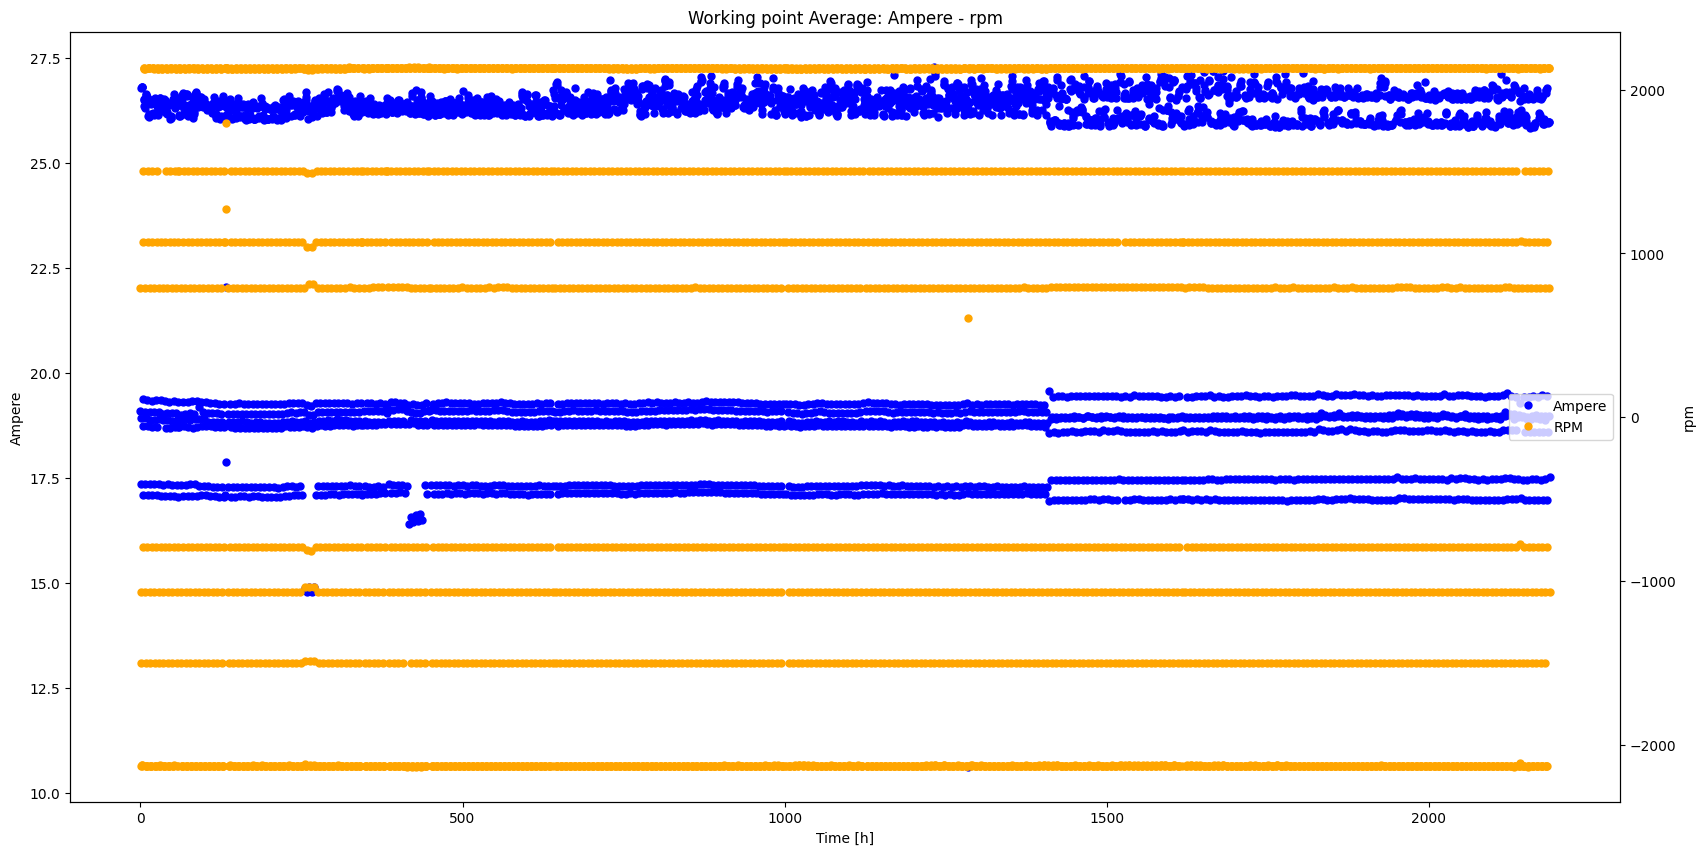

In [ ]:
# Create a new figure
plt.figure(figsize=(20,10))

# Plot Ampere data and store the handle
ampere_plot, = plt.plot(STM7Bdata_ft_418['Ampere'], '.', color='blue', markersize=10)

# Set the label for the y-axis on the left
plt.ylabel('Ampere')

# Set the x-label
plt.xlabel('Time [h]')

# Plot RPM data on the secondary y-axis and store the handle
rpm_plot, = plt.twinx().plot(STM7Bdata_ft_418['RPM'], '.', color='orange', markersize=10)

# Set the label for the y-axis on the right
plt.ylabel('rpm')

# Set the title of the figure
plt.title('Working point Average: Ampere - rpm')

# Specify the x-tick labels
x_labels = [0, 500, 1000, 1500, 2000]  # The hours you want to display
x_ticks = [2*hour for hour in x_labels]  # Convert hours to samples

# Set the x-tick labels
plt.xticks(x_ticks, x_labels)

# Manually set the legend
plt.legend([ampere_plot, rpm_plot], ['Ampere', 'RPM'])

# Show the plot
plt.show()

The data that deviates the most from the well-defined static distributions throughout the test stems mainly from some start-up transients. This is more noticeable on Amps than RPM, which remain much more stable in percentage terms throughout the test. In order to better visualise these 'critical' points, we move to a visualisation where the input data defining our analysis domain are Ampere - RPM. 

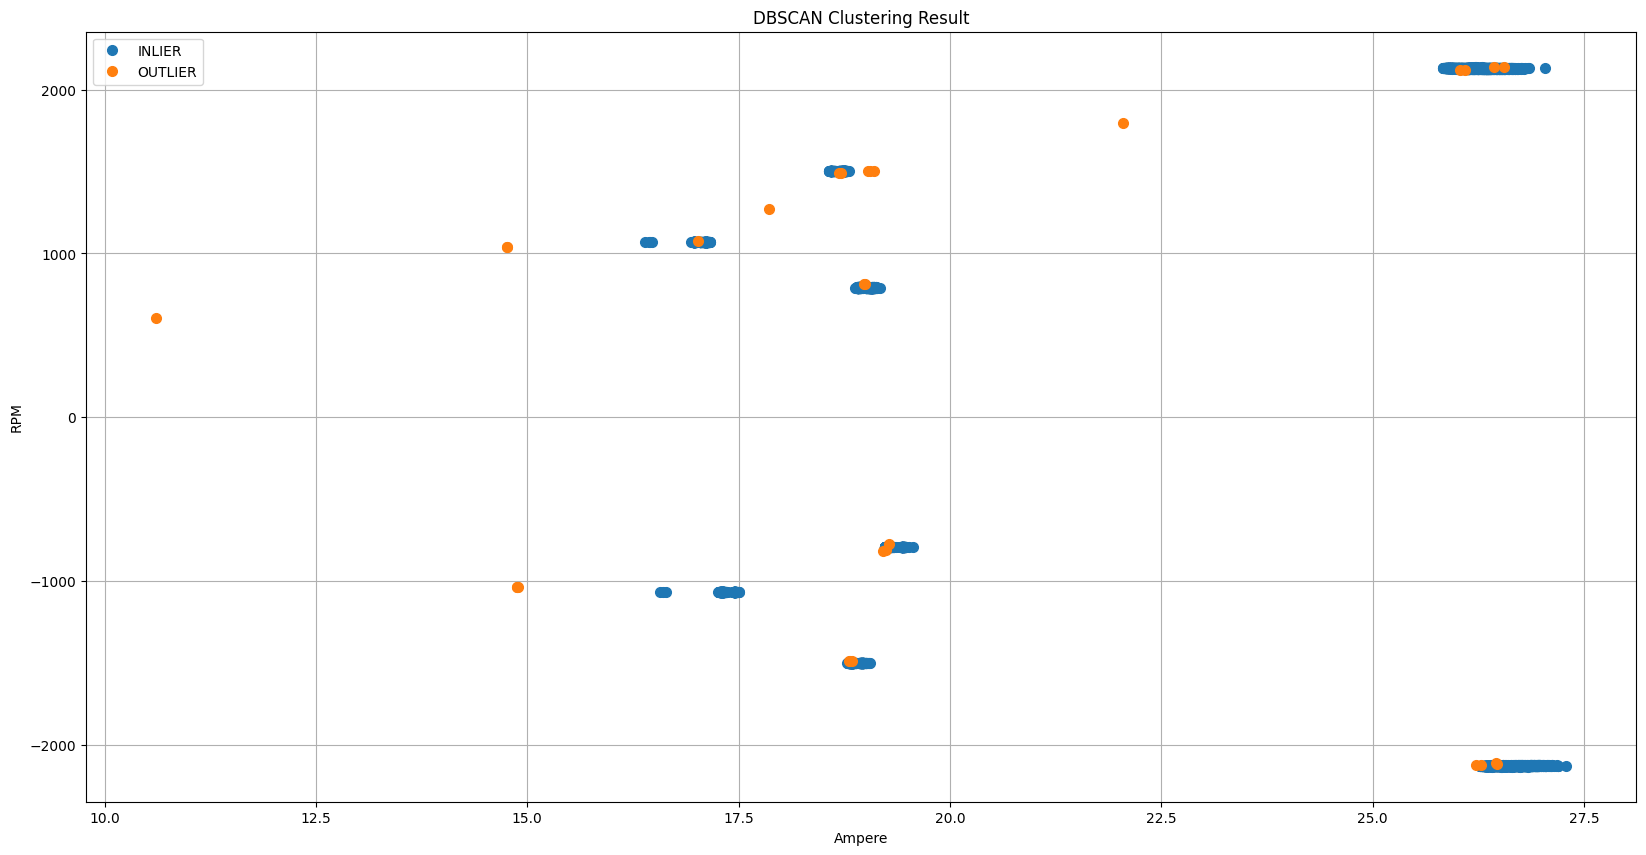

In [ ]:
from sklearn.cluster import DBSCAN

# Assuming STM7Bdata is your DataFrame containing the data
# Extract the first two columns for clustering
data_for_clustering = STM7Bdata_ft_418.iloc[:, 0:2].values

# Perform DBSCAN clustering
db = DBSCAN(eps=1, min_samples=5).fit(data_for_clustering)
idx_class = db.labels_


# Plot the inliers and outliers separately
plt.figure(figsize=(20,10))
plt.plot(data_for_clustering[idx_class != -1, 0], data_for_clustering[idx_class != -1, 1], '.', markersize=14, label='INLIER')
plt.plot(data_for_clustering[idx_class == -1, 0], data_for_clustering[idx_class == -1, 1], '.', markersize=14, label='OUTLIER')
plt.legend()
plt.title('DBSCAN Clustering Result')
plt.xlabel('Ampere')
plt.ylabel('RPM')
plt.grid(True)
plt.show()

In this graph we can see all 4376 points representing the Ampere - RPM inputs of the dataset containing the synthetic data of each acquisition. We went to apply the DBSCAN clustering algorithm in this first approach to identify the 2 classes {'INLIER' and 'OUTLIER'}. During the pre-processing phase of the dataset we are going to eliminate the OUTLIERs as they are data that are more distant from the Working Points that define the test and above all they are few compared to the remaining part of the dataset and therefore it would not be possible to make a statistical analysis of them.

Clusterizzazione dei dati attraverso diversi algoritmi considerando gli OUTLIERS

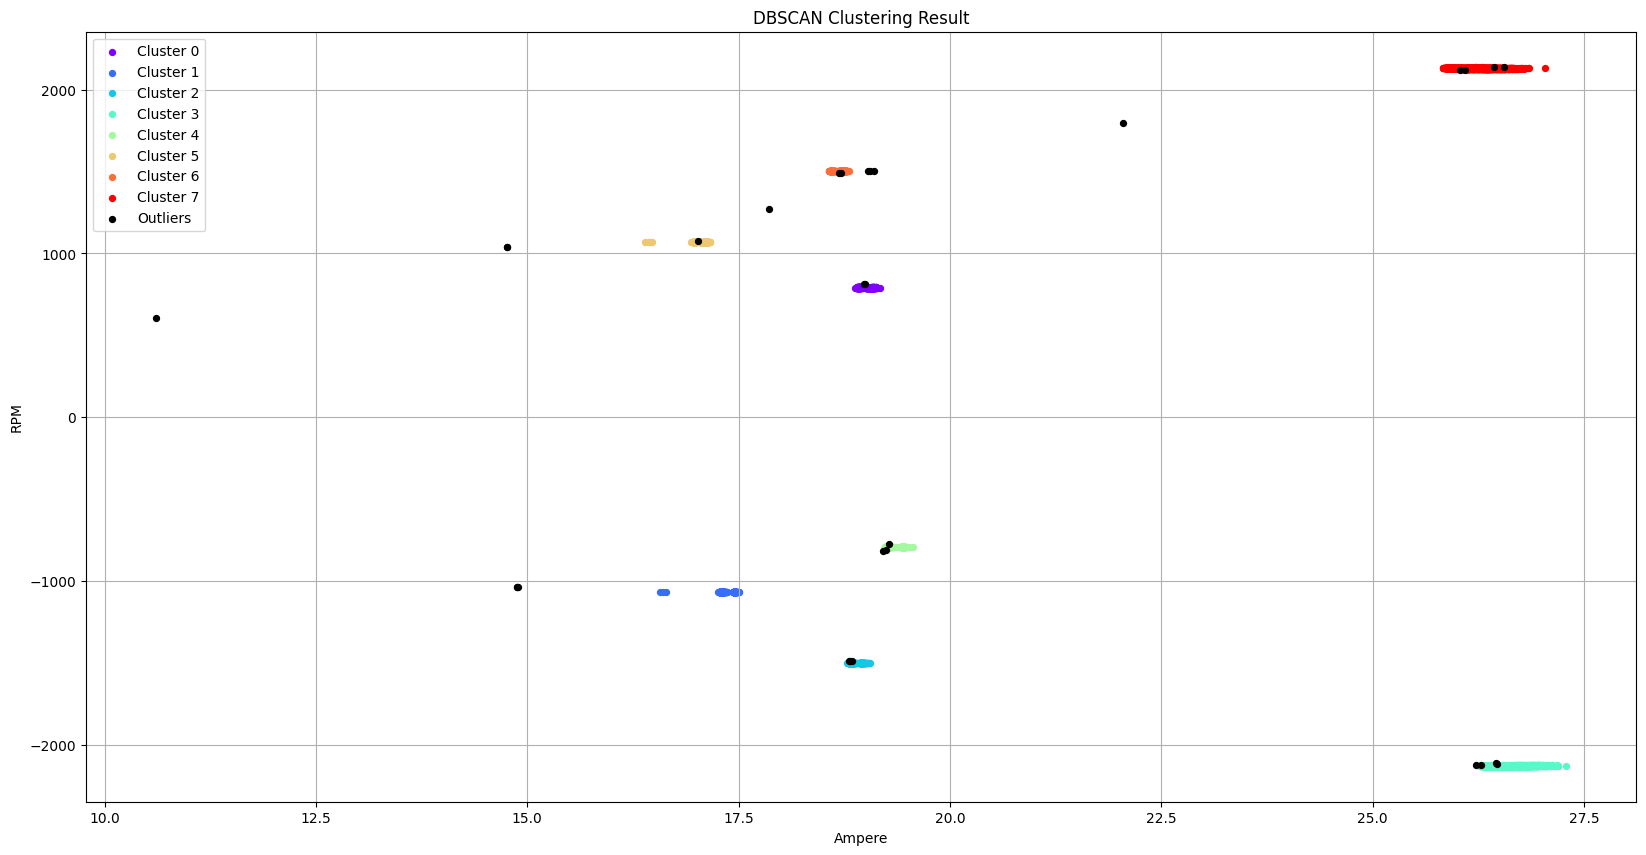

In [ ]:
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(idx_class)) - (1 if -1 in idx_class else 0)

# Create a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))

# Plot clusters with different colors
plt.figure(figsize=(20,10))
for i in range(n_clusters):
    cluster_data = data_for_clustering[idx_class == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color=colors[i], s=18, label=f'Cluster {i}')

# Plot outliers (cluster label -1) in a different color
outlier_data = data_for_clustering[idx_class == -1]
plt.scatter(outlier_data[:, 0], outlier_data[:, 1], color='black', s=18, label='Outliers')

plt.title('DBSCAN Clustering Result')
plt.xlabel('Ampere')
plt.ylabel('RPM')
plt.grid(True)
plt.legend()
plt.show()

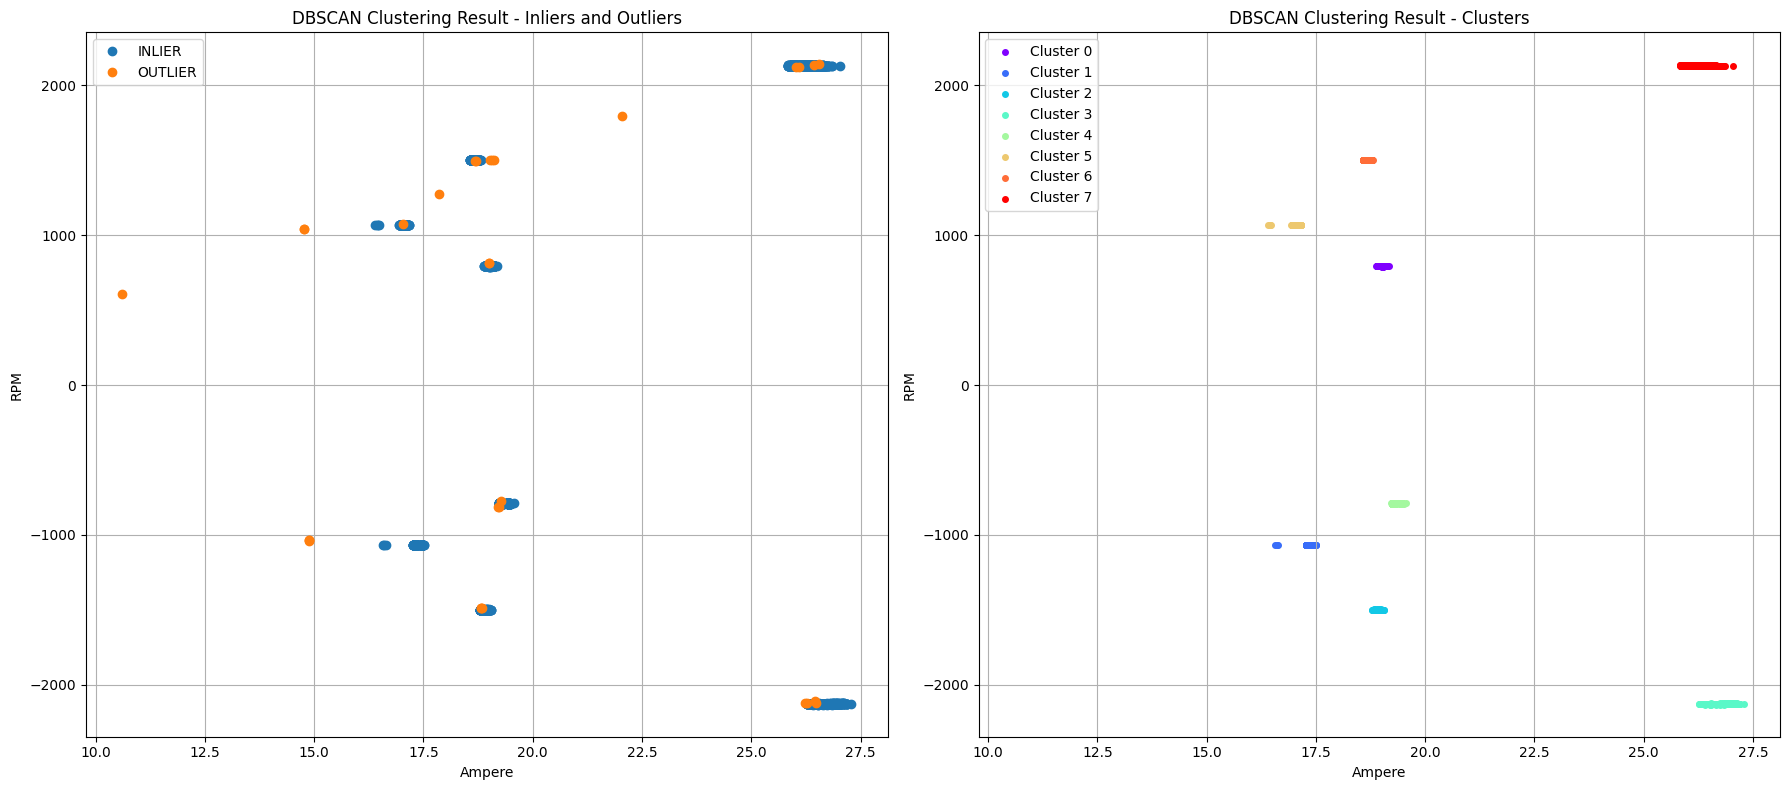

In [ ]:
# Assuming data_for_clustering is your data
# Perform DBSCAN clustering
db = DBSCAN(eps=1, min_samples=5).fit(data_for_clustering)
idx_class = db.labels_

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot the inliers and outliers separately in the first subplot
axes[0].plot(data_for_clustering[idx_class != -1, 0], data_for_clustering[idx_class != -1, 1], '.', markersize=12, label='INLIER')
axes[0].plot(data_for_clustering[idx_class == -1, 0], data_for_clustering[idx_class == -1, 1], '.', markersize=12, label='OUTLIER')
axes[0].legend()
axes[0].set_title('DBSCAN Clustering Result - Inliers and Outliers')
axes[0].set_xlabel('Ampere')
axes[0].set_ylabel('RPM')
axes[0].grid(True)

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(idx_class)) - (1 if -1 in idx_class else 0)

# Create a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))

# Plot clusters with different colors in the second subplot
for i in range(n_clusters):
    cluster_data = data_for_clustering[idx_class == i]
    axes[1].scatter(cluster_data[:, 0], cluster_data[:, 1], color=colors[i], s=16, label=f'Cluster {i}')
axes[1].set_title('DBSCAN Clustering Result - Clusters')
axes[1].set_xlabel('Ampere')
axes[1].set_ylabel('RPM')
axes[1].grid(True)
axes[1].legend()

# Set the same axis limits for both subplots
xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In this graph, one can see the effect of removing the OUTLIERS in the INPUT domain of our dataset.

In [ ]:
import plotly.graph_objects as go

# Create a colormap
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))

# Convert colors to hex format for Plotly
colors_hex = ["#"+"".join([f"{int(c*255):02x}" for c in rgb[:3]]) for rgb in colors]

# Create a Plotly figure
fig = go.Figure()

# Add scatter plots for each cluster
for i in range(n_clusters):
    cluster_data = data_for_clustering[idx_class == i]
    # Calculate the mean of 'Ampere' and 'RPM' for the current cluster
    mean_ampere = np.mean(cluster_data[:, 0])
    mean_rpm = np.mean(cluster_data[:, 1])
    fig.add_trace(go.Scatter(x=cluster_data[:, 0], y=cluster_data[:, 1], 
                             mode='markers', 
                             marker=dict(color=colors_hex[i]),
                             name=f'WP {i}: {mean_ampere:.2f} [A], {mean_rpm:.2f} [RPM]'))

# Add scatter plot for outliers (cluster label -1)
outlier_data = data_for_clustering[idx_class == -1]
fig.add_trace(go.Scatter(x=outlier_data[:, 0], y=outlier_data[:, 1], 
                         mode='markers', 
                         marker=dict(color='black'),
                         name='Outliers'))

# Set plot title and labels
fig.update_layout(title='DBSCAN Clustering Result',
                  xaxis_title='Ampere',
                  yaxis_title='RPM')

# Set plot title and labels
fig.update_layout(
    title={
        'text': 'DBSCAN Clustering Result',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Ampere',
    yaxis_title='RPM',
    autosize=True,
    #width=1750,  # Set the width of the figure
    #height=800,  # Set the height of the figure
)

# Show the plot
fig.show()

# Save the figure to an HTML file
#py.write_html(fig, 'DBSCAN_Clustering_Result.html')

We provide a further visualisation of the working points on which the gearbox works during the entire test by defining the median mean and standard deviation. 

In [ ]:
# Create a DataFrame with the mean Ampere and RPM values for each working point
data = {'Working Point': [f'WP {i}' for i in range(n_clusters)],
        'Mean Ampere': [np.mean(data_for_clustering[idx_class == i, 0]) for i in range(n_clusters)],
        'Mean RPM': [np.mean(data_for_clustering[idx_class == i, 1]) for i in range(n_clusters)],
        'Median Ampere': [np.median(data_for_clustering[idx_class == i, 0]) for i in range(n_clusters)],
        'Median RPM': [np.median(data_for_clustering[idx_class == i, 1]) for i in range(n_clusters)],
        'Std Ampere': [np.std(data_for_clustering[idx_class == i, 0]) for i in range(n_clusters)],      
        'Std RPM': [np.std(data_for_clustering[idx_class == i, 1]) for i in range(n_clusters)]}
df = pd.DataFrame(data)

# Convert the DataFrame to a Markdown table
markdown_table = df.to_markdown(index=False)

from IPython.display import display, Markdown
display(Markdown(markdown_table))

| Working Point   |   Mean Ampere |   Mean RPM |   Median Ampere |   Median RPM |   Std Ampere |   Std RPM |
|:----------------|--------------:|-----------:|----------------:|-------------:|-------------:|----------:|
| WP 0            |       19.0175 |    791.853 |         19.0486 |      791.873 |    0.0738122 |  0.445003 |
| WP 1            |       17.3535 |  -1065.49  |         17.3204 |    -1065.55  |    0.105408  |  0.226367 |
| WP 2            |       18.8844 |  -1498.86  |         18.8509 |    -1498.85  |    0.0658897 |  0.293174 |
| WP 3            |       26.5912 |  -2128.47  |         26.5705 |    -2128.18  |    0.18919   |  1.68989  |
| WP 4            |       19.3318 |   -790.81  |         19.2817 |     -790.83  |    0.0883986 |  0.287024 |
| WP 5            |       17.051  |   1069.09  |         17.0898 |     1069.06  |    0.0956296 |  0.376393 |
| WP 6            |       18.6886 |   1502.87  |         18.7179 |     1502.87  |    0.0685601 |  0.39015  |
| WP 7            |       26.1942 |   2130.73  |         26.1802 |     2130.4   |    0.204902  |  1.63182  |

In [ ]:
# Generate the table that contain the columns of the labeled Working Point
# Assuming db.labels_ contains the labels array
labels = db.labels_

# Assign the labels to a new column in the DataFrame
STM7Bdata_ft_418_labeled = STM7Bdata_ft_418.assign(Working_Point=labels)

In [ ]:
# Generate the table of the features grouped for Working Point with mov(mean/median/std)
 # Convert 'Working_Point' column to categorical and get categories
STM7Bdata_ft_418_labeled['Working_Point'] = pd.Categorical(STM7Bdata_ft_418_labeled['Working_Point'])
categories = STM7Bdata_ft_418_labeled['Working_Point'].cat.categories

# Removing -1 category
idx_rm = STM7Bdata_ft_418_labeled.loc[STM7Bdata_ft_418_labeled["Working_Point"] == -1].index
STM7Bdata_ft_418_WP_labeled = STM7Bdata_ft_418_labeled.drop(idx_rm)
#STM7Bdata_ft_418_WP_labeled = STM7Bdata_ft_418_labeled.drop(idx_rm,inplace=True)

# Initialize empty DataFrames for mean, median, and standard deviation
Data_mean_ft = pd.DataFrame(index=STM7Bdata_ft_418_labeled.index, columns=Name[0:418])
Data_median_ft = pd.DataFrame(index=STM7Bdata_ft_418_labeled.index, columns=Name[0:418])
Data_STD_ft = pd.DataFrame(index=STM7Bdata_ft_418_labeled.index, columns=Name[0:418])

# Define categories without -1
valid_categories = categories[categories != -1]

# Calculate mean, median, and standard deviation for each category
for category in categories:
      if category != -1:  # Exclude category -1
        Idx_WP_selected = STM7Bdata_ft_418_labeled.index[STM7Bdata_ft_418_labeled['Working_Point'] == category]
        for idx_ft in range(0, 418):
            Data_mean_ft.loc[Idx_WP_selected, Name[idx_ft]] = STM7Bdata_ft_418_labeled.loc[Idx_WP_selected, Name[idx_ft]].rolling(window=20,step=1,min_periods=0).mean()
            Data_median_ft.loc[Idx_WP_selected, Name[idx_ft]] = STM7Bdata_ft_418_labeled.loc[Idx_WP_selected, Name[idx_ft]].rolling(window=20,step=1,min_periods=0).median()
            Data_STD_ft.loc[Idx_WP_selected, Name[idx_ft]] = STM7Bdata_ft_418_labeled.loc[Idx_WP_selected, Name[idx_ft]].rolling(window=20,step=1,min_periods=0).std()

# Create DataFrames for mean, median, and standard deviation
STM7B_mean_WP = pd.concat([STM7Bdata_ft_418_labeled['Working_Point'], Data_mean_ft], axis=1)
STM7B_median_WP = pd.concat([STM7Bdata_ft_418_labeled['Working_Point'], Data_median_ft], axis=1)
STM7B_STD_WP = pd.concat([STM7Bdata_ft_418_labeled['Working_Point'], Data_STD_ft], axis=1)

# Create a dictionary that groups the three tables
STM7B_WP_moving_ft = {'WP_mean': STM7B_mean_WP, 'WP_median': STM7B_median_WP, 'WP_std': STM7B_STD_WP}

The newly created dictionary contains the 3 DataFrames in which the mean, median and standard deviation generated for each feature are shown for each Working Point. In this way, having considered a window of 20 acquisitions, which refer to 10 hours of gearbox work, we can have a better visualisation of the trends of the features over time, and we can easily trace which Working Point they belong to. 

# Definition of gearbox life periods by oil data analysis

This section reads and processes the oil data coming from the TDMS file. In particular, they are contained in the 'CAN 0_Average' group in the 'CAN_OLIO_1_Fine' channel. This channel contains the reading of the specific sensor for ferrous particles in the gearbox lubrication oil.

In [ ]:
# Create an instance of the TdmsFile object
Test7B = TdmsFile.read('C:/AASourceCode/Notebook/CoMo_nb/STM_test7B_repository/Test7B_MetaData_Results.tdms')

# Use dir() to list all the attributes and methods of the object
attributes_methods = dir(Test7B)

# Get a list of all group names
group_names = Test7B.groups()

# Access a specific group and get a list of channels within that group
group_name = 'CAN 0_Average'  # Example group name
channels_in_group = Test7B[group_name].channels()

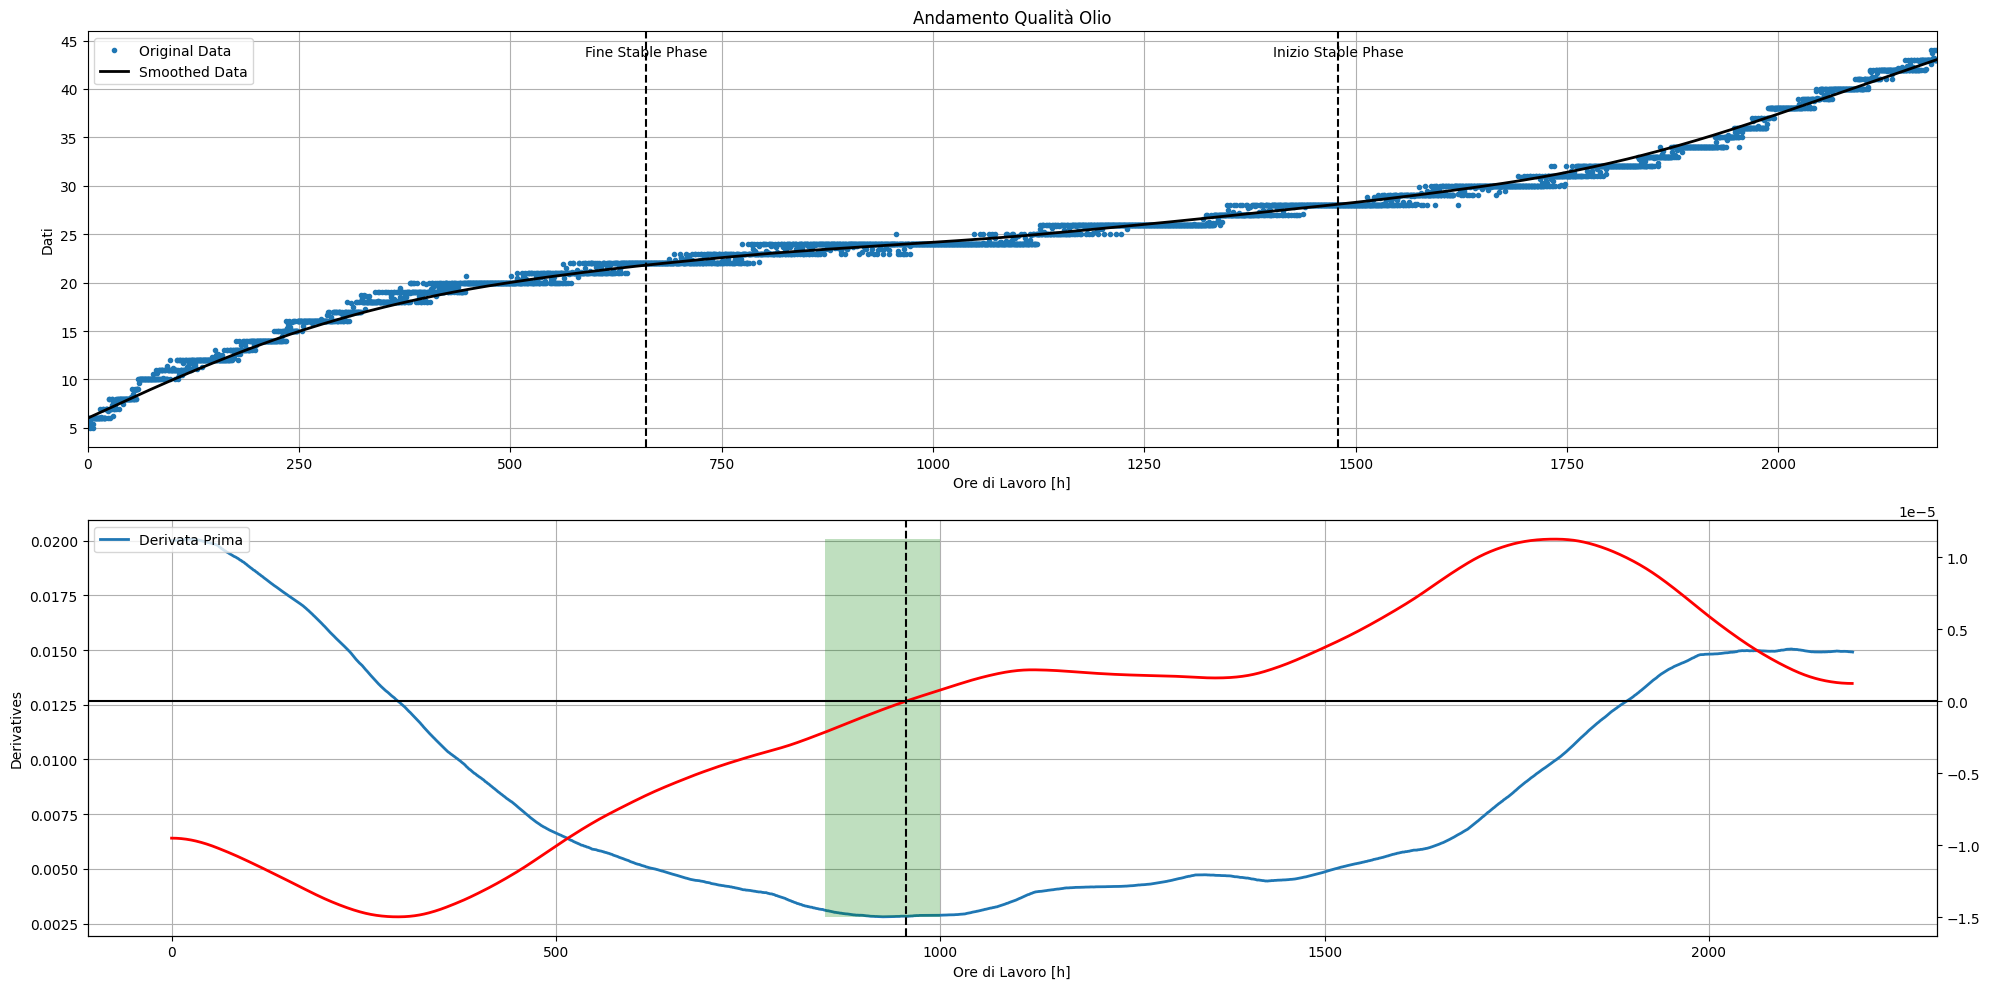

In [ ]:
from scipy.signal import filtfilt

# Define the window length
windows_length = 600

# Create subplots
plt.figure(figsize=(20, 10))

# Plot for Qualità Olio
plt.subplot(2, 1, 1)
plt.title('Andamento Qualità Olio')
plt.xlabel('Ore di Lavoro [h]')
plt.ylabel('Dati')

# Original data
time = np.arange(0, 4376) / 2
data = Test7B['CAN 0_Average']['CAN0_OLIO_1_Fine'].data
plt.plot(time, data, '.', label='Original Data')

# Smoothed data
smoothed_data = filtfilt(np.ones(windows_length), windows_length, data)
plt.plot(time, smoothed_data, 'k-', linewidth=2, label='Smoothed Data')
plt.xlim([0, 4375 / 2])
plt.grid(True)
plt.legend()

# Second subplot for derivatives
plt.subplot(2, 1, 2)
plt.xlabel('Ore di Lavoro [h]')
plt.ylabel('Derivatives')
plt.grid(True)

# First derivative
d1 = np.diff(smoothed_data)
percentile_25_d1 = np.percentile(d1, 35)
plt.plot(time[:-1], d1, linewidth=2, label='Derivata Prima')
#plt.axhline(percentile_25_d1, color='r', linestyle='--', label='25th Percentile')
plt.legend(loc='upper left')

# Second derivative
d2 = np.diff(filtfilt(np.ones(windows_length), windows_length, d1))

# Create a twin y-axis
ax2 = plt.gca().twinx()
ax2.plot(time[:-2], d2, 'r-', linewidth=2, label='Derivata Seconda')
ax2.axhline(0, color='k')
Rod_idx = np.where(d2 > 0)[0][0]/2 # Divide by 2 to match time scale
ax2.axvline(Rod_idx, color='k', linestyle='--')
#plt.text(Rod_idx, plt.ylim()[1] - 2.5, 'Fine Rodaggio', color='k', fontsize=10, ha='center')
#ax2.xlim([0, 4374.5 / 2])

# Find the minimum and maximum values of d2
min_d2 = np.min(d2)
max_d2 = np.max(d2)

# Define the vertices for the polygon that indicates the TrainingSet
x = [850, 1000, 1000, 850]
y = [min_d2, min_d2, max_d2, max_d2]

# Plot the filled polygon with green color and transparency
ax2.fill(x, y, 'g', alpha=0.25)

#idx_start_d2 = np.where(d2 > 0)[0][0]
#ax2.axvline(time[idx_start_d2], color='g', linestyle='--', label='Fine Rodaggio')


# Marking start of Stable Phase
plt.subplot(2, 1, 1)
sorted_index = np.argsort(np.abs(d1 - percentile_25_d1))[:2]
plt.axvline(time[sorted_index[0]], color='k', linestyle='--')
plt.text(time[sorted_index[0]], plt.ylim()[1] - 2.5, 'Inizio Stable Phase', color='k', fontsize=10, ha='center')
plt.axvline(time[sorted_index[1]], color='k', linestyle='--')
plt.text(time[sorted_index[1]], plt.ylim()[1] - 2.5, 'Fine Stable Phase', color='k', fontsize=10, ha='center')
plt.legend()
plt.xlim([0, 4374.5 / 2])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

As can be seen from the graph, the upper sub-plot shows the trend of the 'raw' signal measuring the oil quality inside the gearbox housing, and the signal filtered with a zero-phase filter is also shown. In the lower subplot, the first- and second-degree derivatives are shown. These were used to highlight and select the various phases of the gearbox's life. In particular, the trend of the first derivative reminds us of the famous 'bathtub curve'. It is composed of 3 different types of failure: the area of early failures (or infant mortality, where the failure rate is decreasing with time), the area of physical life (where the failure rate remains constant with time), and the area of generalised wear (or wear out, where the failure rate becomes increasing very rapidly due to wear). Thus, it can be concluded that there is a close correlation between the failure rate and the variation over time of the ferrous particles released from the contact surfaces of the gear wheels. 

# Processing the dataset for further visualisation

In [ ]:
# Define the indices for each category
indices = [(200, 500), (1700, 2000), (4000, 4300)]

# Extract the data for each category and concatenate
categories_data = []
for start, end in indices:
    category_data = STM7Bdata_ft_418_labeled.iloc[start:end+1] #remember to remove the OUTLIERS and use only the Dataset with the Working Point
    categories_data.append(category_data)
STM7B_WP_classification = pd.concat(categories_data)

# Create the faultcode labels
faultcode = pd.Series(['Rodaggio'] * 301 + ['Stabile'] * 301 + ['Finale'] * 301)

# Ensure that the length of the faultcode series matches the length of the concatenated DataFrame
if len(faultcode) != len(STM7B_WP_classification):
    raise ValueError("Length of faultcode series does not match the length of the DataFrame")

# Add the faultcode column to the DataFrame
STM7B_WP_classification.reset_index(drop=True, inplace=True)
STM7B_WP_classification['FaultCode'] = faultcode

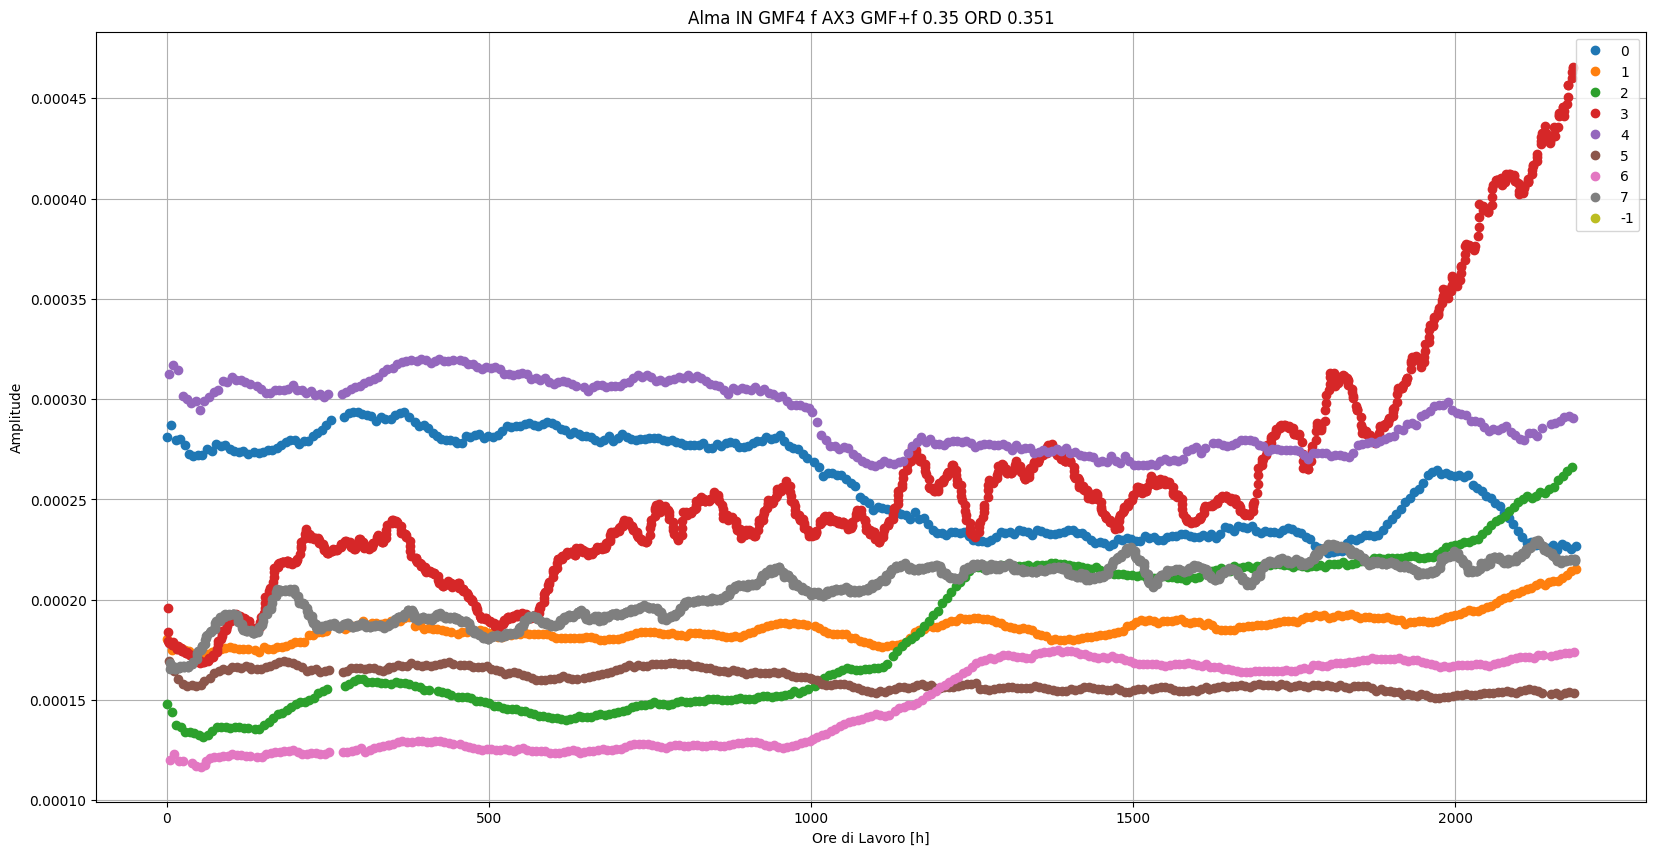

In [ ]:
# Get the variable names and categories
Name = STM7B_WP_moving_ft['WP_mean'].columns
Categories = STM7B_WP_moving_ft['WP_mean']['Working_Point'].unique()

# Select the data you want to plot
Data = STM7B_WP_moving_ft['WP_mean']

for idx_ft in range(103, 104):
    plt.figure(figsize=(20,10))
    plt.title(Name[idx_ft].replace('_', ' '))
    plt.grid(True)

    for idx_WP in range(len(Categories)):
        Idx_WP_selected = np.where(Data['Working_Point'] == Categories[idx_WP])

        plt.plot(Idx_WP_selected[0]/2, Data[Name[idx_ft]].iloc[Idx_WP_selected], '.', markersize=12)

    for start, end in indices:
        # Get the data between 'start' and 'end'
        data_between = Data[Name[idx_ft]].iloc[Idx_WP_selected[0][(Idx_WP_selected[0] >= start) & (Idx_WP_selected[0] < end)]]
        
        # Check if data_between is not empty
        if not data_between.empty:
            plt.fill_between(range(start, end), min(data_between), max(data_between), facecolor='green', alpha=0.25)

    plt.legend(Categories)
    plt.xlabel('Ore di Lavoro [h]')
    plt.ylabel('Amplitude')
    plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output

# Create a dropdown menu for selecting the variable
dropdown_ft = widgets.Dropdown(options=Name, description='Variable:')
display(dropdown_ft)

def plot_graph(variable):
    clear_output(wait=True)  # Clear the output
    display(dropdown_ft)  # Redisplay the dropdown menu
    
    fig = go.Figure()  # Initialize the figure outside of the loop

    idx_ft = list(Name).index(variable)  # Get the index of the selected variable
    color_map = {'Rodaggio': 'yellow', 'Stabile': 'green', 'Finale': 'red'}  # Map faultcode to color

    # Add invisible scatter traces for the legend
    for code, color in color_map.items():
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            showlegend=True,
            name=code
        ))

    for idx_WP in range(len(Categories)):
        # Skip the iteration if the category is -1
        if Categories[idx_WP] == -1:
            continue

        Idx_WP_selected = np.where(Data['Working_Point'] == Categories[idx_WP])

        # Calculate the mean of 'Ampere' and 'RPM' for the current category
        mean_ampere = Data['Ampere'].iloc[Idx_WP_selected].mean()
        mean_rpm = Data['RPM'].iloc[Idx_WP_selected].mean()

        fig.add_trace(go.Scatter(
            x=Idx_WP_selected[0]/2,
            y=Data[variable].iloc[Idx_WP_selected],
            mode='markers',
            name=f'WP {Categories[idx_WP]}: {mean_ampere:.2f} [A], {mean_rpm:.2f} [RPM]'  # Include the means in the legend
        ))

    # Add the first vertical band (yellow)
    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=200/2,
        y0=0,
        x1=500/2,
        y1=1,
        fillcolor='yellow',
        opacity=0.25,
        layer="below",
        line_width=0,
    )

    # Add the second vertical band (green)
    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=1700/2,
        y0=0,
        x1=2000/2,
        y1=1,
        fillcolor='green',
        opacity=0.25,
        layer="below",
        line_width=0,
    )

    # Add the third vertical band (red)
    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=4000/2,
        y0=0,
        x1=4300/2,
        y1=1,
        fillcolor='red',
        opacity=0.25,
        layer="below",
        line_width=0,
    )

    fig.update_layout(
        title=variable.replace('_', ' '),
        title_x=0.5,
        xaxis_title='Ore di Lavoro [h]',
        yaxis_title='Amplitude',
        autosize=False,
        width=1000,
        height=500,
    )

    fig.show()

# Call the function when the dropdown value changes
dropdown_ft.observe(lambda change: plot_graph(change.new), names='value')

Dropdown(description='Variable:', index=7, options=('Working_Point', 'Ampere', 'RPM', 'Alma_IN_RMS', 'Alma_IN_…

# Classification of gearbox life stages

In this section, the labelling of the data is done. The dataset is divided into 3 categories: "Running-in", "Stable Phase", "Final Phase". For each category described above, 300 acquisition points are selected out of the total of the entire dataset of 4376, i.e. approximately 7%. The temporal selection of the datasets necessary to populate the classes described was evaluated by referring to the oil quality trend, in fact the dataset labelled "Stable Phase" coincides with the training set selected to do Novelty Detection.

In [ ]:
# Define the indices for each category
indices = [(200, 500), (1700, 2000), (4000, 4300)]

# Extract the data for each category and concatenate
categories_data = []
for start, end in indices:
    category_data = STM7Bdata_ft_418_labeled.iloc[start:end+1] #remember to remove the OUTLIERS and use only the Dataset with the Working Point
    categories_data.append(category_data)
STM7B_WP_classification = pd.concat(categories_data)

# Create the faultcode labels
#faultcode = pd.concat([pd.Series(['Rodaggio'] * 301), pd.Series(['Stabile'] * 301), pd.Series(['Finale'] * 301)], ignore_index=True)
faultcode = pd.Series(['Rodaggio'] * 301 + ['Stabile'] * 301 + ['Finale'] * 301)

# Ensure that the length of the faultcode series matches the length of the concatenated DataFrame
if len(faultcode) != len(STM7B_WP_classification):
    raise ValueError("Length of faultcode series does not match the length of the DataFrame")

# Add the faultcode column to the DataFrame
STM7B_WP_classification.reset_index(drop=True, inplace=True)
STM7B_WP_classification['FaultCode'] = faultcode

Train classification Model using the previos dataset labeled

In [ ]:
# Separate features and target variable
X = STM7B_WP_classification.drop(columns=['FaultCode'])
y = STM7B_WP_classification['FaultCode']

# Initialize the decision tree classifier
clf = DecisionTreeClassifier()

# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store accuracy scores for each fold
accuracy_scores = []

# Perform 5-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the model for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(f"Accuracy for {clf.__class__.__name__}: ", accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print(f"Mean Accuracy for {clf.__class__.__name__}: ", mean_accuracy)

Accuracy for DecisionTreeClassifier:  0.9779005524861878
Accuracy for DecisionTreeClassifier:  0.9834254143646409
Accuracy for DecisionTreeClassifier:  0.9558011049723757
Accuracy for DecisionTreeClassifier:  0.9777777777777777
Accuracy for DecisionTreeClassifier:  0.9666666666666667
Mean Accuracy for DecisionTreeClassifier:  0.9723143032535297


This time we train the model using cross-validation with 5 folders

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Remove rows with NaN values
STM7B_WP_classification.dropna(inplace=True)

# Separate features and target variable
X = STM7B_WP_classification.drop(columns=['FaultCode'])
y = STM7B_WP_classification['FaultCode']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the decision tree classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9834254143646409


Test the classification Model using all the dataset

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Separate features and target variable
X_test = STM7B_WP_classification.drop(columns=['FaultCode'])
y_test = STM7B_WP_classification['FaultCode']

# Use the trained classifier to predict the target variable
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

len(y_pred)


Accuracy: 0.9933554817275747
Precision: 0.9933699055524281
Recall: 0.9933554817275747
F1 Score: 0.993355408388521


903

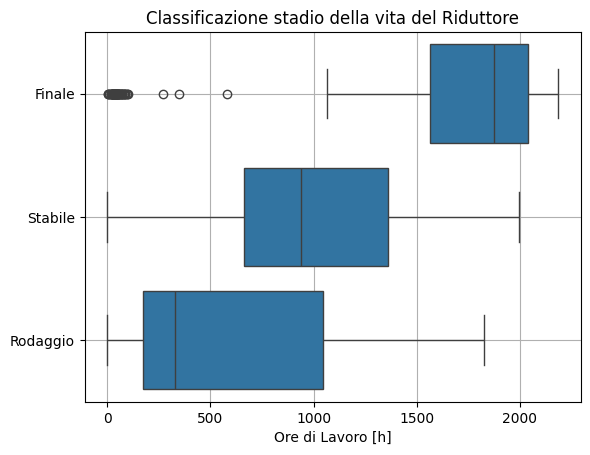

In [ ]:
# Use the trained DecisionTreeClassifier model to predict the labels for STM7Bdata_ft_418_WP_labeled
y_pred = clf.predict(STM7Bdata_ft_418_labeled)

# Plot the predicted labels
import matplotlib.pyplot as plt
import seaborn as sns

# Define the order
order = ['Rodaggio', 'Stabile', 'Finale']

# Convert the category labels to an ordered categorical type
y_pred_ordered = pd.Categorical(y_pred, categories=order, ordered=True)

# Create a DataFrame with the range (1:4337)/2 as 'x' and y_pred as 'y'
df = pd.DataFrame({
    'x': np.arange(len(y_pred_ordered)) / 2,
    '': y_pred_ordered
})

# Create a horizontal boxplot
sns.boxplot(x='x', y='', data=df, orient='h')

plt.xlabel('Ore di Lavoro [h]')
plt.title('Classificazione stadio della vita del Riduttore')
plt.grid(True)

# Flip the y-axis
plt.gca().invert_yaxis()

plt.show()

In [ ]:
print(y_pred_ordered.value_counts())

Rodaggio    1083
Stabile     2132
Finale      1161
Name: count, dtype: int64


# Comparison of different Anomaly Detection models

Creation of the DataFrame Group_anomaly Table, containing the feature indices that are associated with the various orders of the frequency analysis of each component on the gearbox. These refer to reduction axes, gearing frequencies, side-bands of the gearing frequencies and all frequencies relating to the bearing components.

In [ ]:
# Define the group names and sensor names
group_name = ['f_AX9_IN', 'GMF1', 'GMF1_f_AX9_IN', 'f_AX1', 'GMF2', 'GMF1_f_AX1', 'GMF2_f_AX2', 'f_AX2', 'GMF3', 'GMF2_f_AX3', 'GMF3_f_AX2', 'f_AX3', 'GMF4', 'GMF3_f_AX3', 'GMF4_f_AX3', 'f_AX4_OUT', 'GMF4_f_AX4_OUT', 'AX9_B1', 'AX9_B2', 'AX1_B1', 'AX1_B2', 'AX2_B1', 'AX2_B2', 'AX3_B1', 'AX3_B2', 'AX4_B1', 'AX4_B2']
sensor_name = ['Alma_IN', 'Alma_OUT']

# Define the Alma_IN indices
alma_in = [list(range(8, 12)), list(range(12, 22)), list(range(22, 28)), list(range(28, 32)), list(range(32, 42)), list(range(42, 48)), list(range(48, 54)), list(range(54, 58)), list(range(58, 68)), list(range(68, 74)), list(range(74, 80)), list(range(80, 84)), list(range(84, 94)), list(range(94, 100)), list(range(100, 106)), list(range(106, 110)), list(range(110, 116)), list(range(116, 120)), list(range(120, 124)), list(range(124, 128)), list(range(128, 132)), list(range(132, 136)), list(range(136, 140)), list(range(140, 144)), list(range(144, 148)), list(range(148, 152)), list(range(152, 156))]

# Calculate the Alma_OUT indices
alma_out = [list(range(i[0]+178, i[-1]+178+1)) for i in alma_in]

# Create a DataFrame
Group_Anomaly = pd.DataFrame({'Alma_IN': alma_in, 'Alma_OUT': alma_out}, index=group_name)

# Transpose the DataFrame
group_anomaly_tb = Group_Anomaly.transpose()

# Rename the same DataFrame as this is the one that will be used
STM7Bdata_ft_418_WP_labeled = STM7Bdata_ft_418_labeled

# Convert the DataFrame to a Markdown table
Group_Anomaly_table = Group_Anomaly.to_markdown()

from IPython.display import display, Markdown
display(Markdown(Group_Anomaly_table))

|                | Alma_IN                                  | Alma_OUT                                           |
|:---------------|:-----------------------------------------|:---------------------------------------------------|
| f_AX9_IN       | [8, 9, 10, 11]                           | [186, 187, 188, 189]                               |
| GMF1           | [12, 13, 14, 15, 16, 17, 18, 19, 20, 21] | [190, 191, 192, 193, 194, 195, 196, 197, 198, 199] |
| GMF1_f_AX9_IN  | [22, 23, 24, 25, 26, 27]                 | [200, 201, 202, 203, 204, 205]                     |
| f_AX1          | [28, 29, 30, 31]                         | [206, 207, 208, 209]                               |
| GMF2           | [32, 33, 34, 35, 36, 37, 38, 39, 40, 41] | [210, 211, 212, 213, 214, 215, 216, 217, 218, 219] |
| GMF1_f_AX1     | [42, 43, 44, 45, 46, 47]                 | [220, 221, 222, 223, 224, 225]                     |
| GMF2_f_AX2     | [48, 49, 50, 51, 52, 53]                 | [226, 227, 228, 229, 230, 231]                     |
| f_AX2          | [54, 55, 56, 57]                         | [232, 233, 234, 235]                               |
| GMF3           | [58, 59, 60, 61, 62, 63, 64, 65, 66, 67] | [236, 237, 238, 239, 240, 241, 242, 243, 244, 245] |
| GMF2_f_AX3     | [68, 69, 70, 71, 72, 73]                 | [246, 247, 248, 249, 250, 251]                     |
| GMF3_f_AX2     | [74, 75, 76, 77, 78, 79]                 | [252, 253, 254, 255, 256, 257]                     |
| f_AX3          | [80, 81, 82, 83]                         | [258, 259, 260, 261]                               |
| GMF4           | [84, 85, 86, 87, 88, 89, 90, 91, 92, 93] | [262, 263, 264, 265, 266, 267, 268, 269, 270, 271] |
| GMF3_f_AX3     | [94, 95, 96, 97, 98, 99]                 | [272, 273, 274, 275, 276, 277]                     |
| GMF4_f_AX3     | [100, 101, 102, 103, 104, 105]           | [278, 279, 280, 281, 282, 283]                     |
| f_AX4_OUT      | [106, 107, 108, 109]                     | [284, 285, 286, 287]                               |
| GMF4_f_AX4_OUT | [110, 111, 112, 113, 114, 115]           | [288, 289, 290, 291, 292, 293]                     |
| AX9_B1         | [116, 117, 118, 119]                     | [294, 295, 296, 297]                               |
| AX9_B2         | [120, 121, 122, 123]                     | [298, 299, 300, 301]                               |
| AX1_B1         | [124, 125, 126, 127]                     | [302, 303, 304, 305]                               |
| AX1_B2         | [128, 129, 130, 131]                     | [306, 307, 308, 309]                               |
| AX2_B1         | [132, 133, 134, 135]                     | [310, 311, 312, 313]                               |
| AX2_B2         | [136, 137, 138, 139]                     | [314, 315, 316, 317]                               |
| AX3_B1         | [140, 141, 142, 143]                     | [318, 319, 320, 321]                               |
| AX3_B2         | [144, 145, 146, 147]                     | [322, 323, 324, 325]                               |
| AX4_B1         | [148, 149, 150, 151]                     | [326, 327, 328, 329]                               |
| AX4_B2         | [152, 153, 154, 155]                     | [330, 331, 332, 333]                               |

In [ ]:
#save the Dataframe STM7Bdata_ft_418_WP_labeled
#STM7Bdata_ft_418_WP_labeled.to_csv('D:\Dottorato\AAData\Phyton Files\STM_Test7B/STM7Bdata_ft_418_WP_labeled.csv', index=False)

Training & Testing of various Anomaly Detection methods, comparison by Group Anomaly (Alma_IN) or (Alma_OUT)

Dropdown(description='Feature:', options=('f_AX9_IN', 'GMF1', 'GMF1_f_AX9_IN', 'f_AX1', 'GMF2', 'GMF1_f_AX1', …

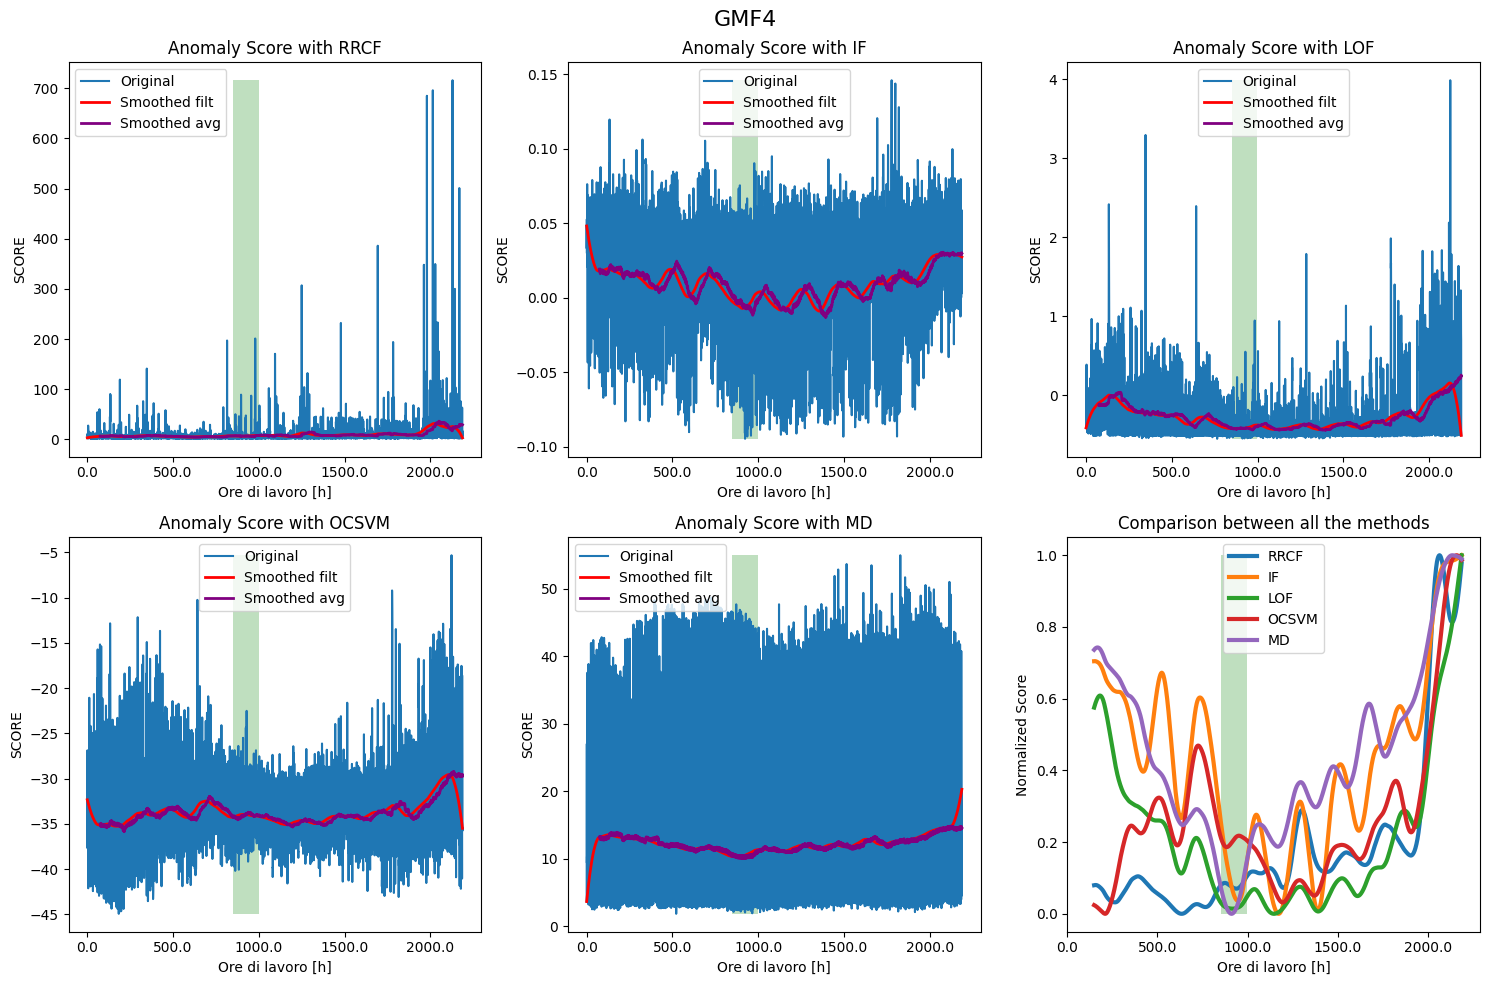

'GMF4' is not a valid key in Group_Anomaly.


<Figure size 1000x600 with 0 Axes>

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from anomaly_detection_idx import anomaly_detection_idx 

# Create a dropdown menu
dropdown = widgets.Dropdown(
    options=Group_Anomaly.index,  # The options in the dropdown menu are the column names of Group_Anomaly
    value=Group_Anomaly.index[0],  # The initial selection is the first column
    description='Feature:',  # The label next to the dropdown menu
)

# Define a function that will be called when a feature is selected
def on_select(change):
    # Get the selected feature
    feature = change['new']
    
    # Find the index of the selected feature in Group_Anomaly.index
    idx = list(Group_Anomaly.index).index(feature)

    # Call the function
    anomaly_detection_idx(STM7Bdata_ft_418_WP_labeled, Group_Anomaly, idx)
    
    # Plot the selected feature
    plt.figure(figsize=(10, 6))
    try:
        plt.plot(Group_Anomaly[feature])
        plt.title(feature)
    except KeyError:
        print(f"'{feature}' is not a valid key in Group_Anomaly.")
    plt.show()

# Set the function to be called when a feature is selected
dropdown.observe(on_select, names='value')

# Display the dropdown menu
display(dropdown)